In [12]:
import json
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# input data - dataset is stored on my local machine
# load config file with file path for datasets
with open("config.json") as f:
    config = json.load(f)

# load datasets
steam_path = config["steam_reviews_path"]
games_path = config["all_games_path"]
steam_df = pd.read_csv(steam_path)
games_df = pd.read_csv(games_path)

# print small sample of data
print("steam reviews sample:\n", steam_df.head())
print("all games sample:\n", games_df.head())

steam reviews sample:
    Unnamed: 0  app_id                  app_name  review_id  language  \
0           0  292030  The Witcher 3: Wild Hunt   85185598  schinese   
1           1  292030  The Witcher 3: Wild Hunt   85185250  schinese   
2           2  292030  The Witcher 3: Wild Hunt   85185111  schinese   
3           3  292030  The Witcher 3: Wild Hunt   85184605   english   
4           4  292030  The Witcher 3: Wild Hunt   85184287  schinese   

                                              review  timestamp_created  \
0                            不玩此生遗憾，RPG游戏里的天花板，太吸引人了         1611381629   
1                                 拔DIAO无情打桩机--杰洛特!!!         1611381030   
2                                              巫师3NB         1611380800   
3  One of the best RPG's of all time, worthy of a...         1611379970   
4                                                 大作         1611379427   

   timestamp_updated  recommended  votes_helpful  ...  steam_purchase  \
0         1611381629

In [3]:
# preprocessing part 1 - filter and clean reviews from raw data
print("filtering for english reviews and cleaning...")
steam_df = steam_df[
    (steam_df['language'] == 'english') &   # english reviews only
    (steam_df['review'].notnull()) &        
    (steam_df['review'].str.len() > 20)     # remove short reviews
]

steam_df['label'] = steam_df['recommended'].astype(int)     # a steam user either recommends or does not recommend
print(f"filtered reviews remaining: {len(steam_df)}")

filtering for english reviews and cleaning...
filtered reviews remaining: 6993649


In [4]:
# preprocessing part 2 - balance dataset by review sentiment + minimum reviews
# label data into positive and negative reviews
neg_reviews = steam_df[steam_df['label'] == 0]
pos_reviews = steam_df[steam_df['label'] == 1]
n = 10000                   # equal sample size to avoid bias to pos/neg - 10 000 reviews each
MIN_REVIEWS_PER_GAME = 20   # filter out games with too few reviews in the sample

# create new balanced dataset
balanced_reviews = pd.concat([
    pos_reviews.sample(n=n, random_state=42),   # 10 000 positive
    neg_reviews.sample(n=n, random_state=42)    # 10 000 negative
]).sample(frac=1, random_state=42)              # shuffle

# count how many times each game appears
game_counts = balanced_reviews['app_name'].value_counts()
# only keep games with at least MIN_REVIEWS_PER_GAME reviews in dataset
valid_games = game_counts[game_counts >= MIN_REVIEWS_PER_GAME].index
filtered_balanced = balanced_reviews[balanced_reviews['app_name'].isin(valid_games)]

# now sample data is not biased to pos/neg and excludes games with few reviews
print(f"\ntotal games before filtering: {len(game_counts)}")
print(f"total games after filtering (≥ {MIN_REVIEWS_PER_GAME} reviews): {len(valid_games)}")
print(f"filtered review count: {len(filtered_balanced)}")


total games before filtering: 309
total games after filtering (≥ 20 reviews): 175
filtered review count: 18808


In [5]:
# text vectorization using tfidf
# tfidf = term frequency-inverse document frequency - converts words to numbers
X_PATH = "X_vectorized.pkl"
y_PATH = "y_labels.pkl"
VECTORIZER_PATH = "tfidf_vectorizer.pkl"

# if data is already loaded, don't load it again to save time
if os.path.exists(X_PATH) and os.path.exists(y_PATH) and os.path.exists(VECTORIZER_PATH):
    print("loading cached vectorized data...")
    X = load(X_PATH)
    y = load(y_PATH)
    vectorizer = load(VECTORIZER_PATH)
# loading for the first time will take longer, dumps files for next time
else:
    print("vectorizing review text using tfidf...")                         # tfidf weighs rarity/importance vs count
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)  # exclude filler words, 10 000 most common words
    X = vectorizer.fit_transform(filtered_balanced['review'])               # feature matrix - review words       
    y = filtered_balanced['label']                                          # target variable - 0/1 label
    dump(X, X_PATH)
    dump(y, y_PATH)
    dump(vectorizer, VECTORIZER_PATH)
    print("vectorized data saved")

loading cached vectorized data...


In [6]:
# split dataset - 80/20 split + stratify to ensure equal pos/neg balance
print("splitting into train/test...")  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)   

splitting into train/test...


In [7]:
# model implementation part 1 - evaluation function
# summary storage for final comparison
results = []

# evaluation helper/runner function for results
def evaluate_model(name, model):
    """
    The evaluate_model function trains and evaluates a classifier on the train/test split.
    It also prints performance metrics: accuracy, precision, recall and F1 and displays a confusion matrix heatmap.
    Args:
        name (str): The name of the model.
        model (sklearn classifier): The model to evaluate.
    """
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)     # fit model to training data
    preds = model.predict(X_test)   # test set predictions

    # performance metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    print(f"{name} accuracy: {acc:.2f}")
    print(f"{name} precision: {prec:.2f}")
    print(f"{name} recall: {rec:.2f}")
    print(f"{name} f1 Score: {f1:.2f}")

    # display confusion matrix as heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

    # store results for final summary
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })


Training Naive Bayes...
Naive Bayes accuracy: 0.85
Naive Bayes precision: 0.86
Naive Bayes recall: 0.83
Naive Bayes f1 Score: 0.84


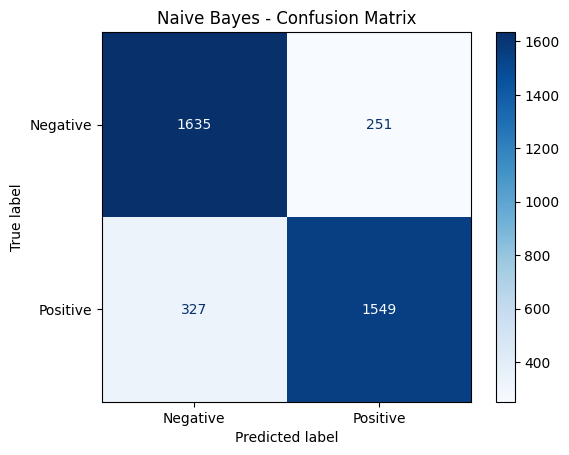


Training Random Forest...
Random Forest accuracy: 0.83
Random Forest precision: 0.82
Random Forest recall: 0.83
Random Forest f1 Score: 0.83


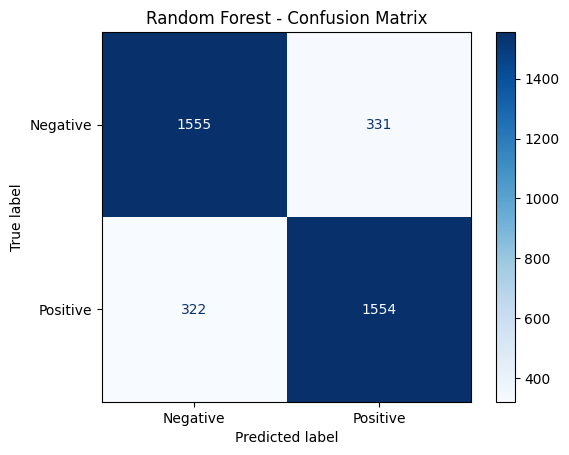


Training SVM (RBF)...
SVM (RBF) accuracy: 0.86
SVM (RBF) precision: 0.85
SVM (RBF) recall: 0.87
SVM (RBF) f1 Score: 0.86


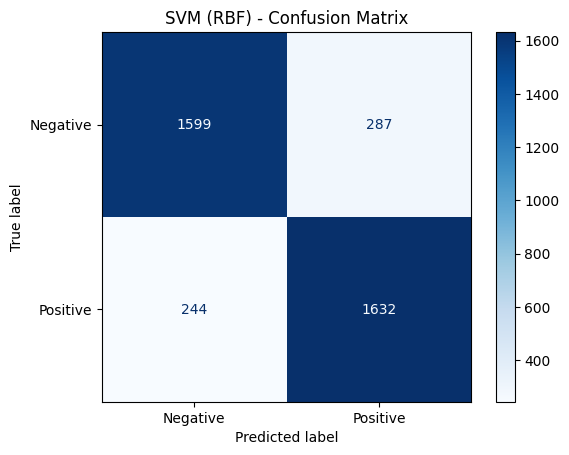


Model Comparison Summary:
        Model  Accuracy  Precision   Recall  F1 Score
    SVM (RBF)  0.858852   0.850443 0.869936  0.860079
  Naive Bayes  0.846358   0.860556 0.825693  0.842764
Random Forest  0.826422   0.824403 0.828358  0.826376

Best Model: SVM (RBF) with F1 Score of 0.86


In [8]:
# model implementation part 2 - model running + final comparison
# run models using evaluation function
evaluate_model("Naive Bayes", MultinomialNB())
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
evaluate_model("Random Forest", rf_model)
evaluate_model("SVM (RBF)", SVC(kernel='rbf', class_weight='balanced'))

# show results in a summary table
results_df = pd.DataFrame(results)
print("\nModel Comparison Summary:")
print(results_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

# print the best model based on F1
best_model = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]
print(f"\nBest Model: {best_model['Model']} with F1 Score of {best_model['F1 Score']:.2f}")

Correlation between predicted Steam sentiment and Metacritic CRITIC score: 0.42


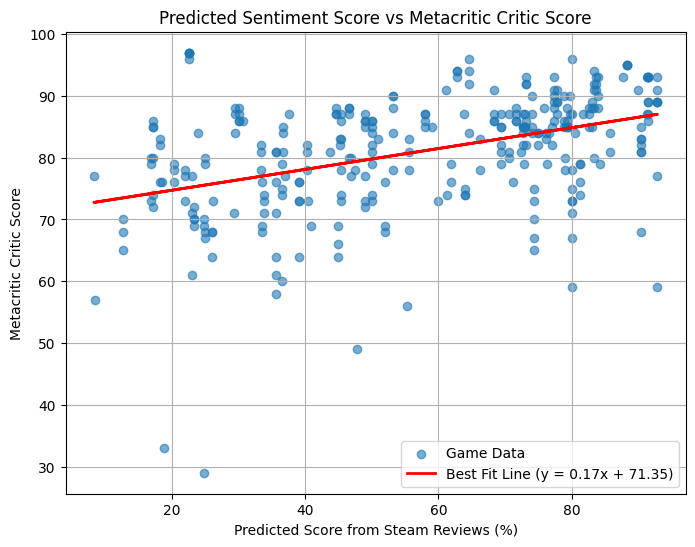

Correlation between predicted Steam sentiment and Metacritic USER score: 0.71


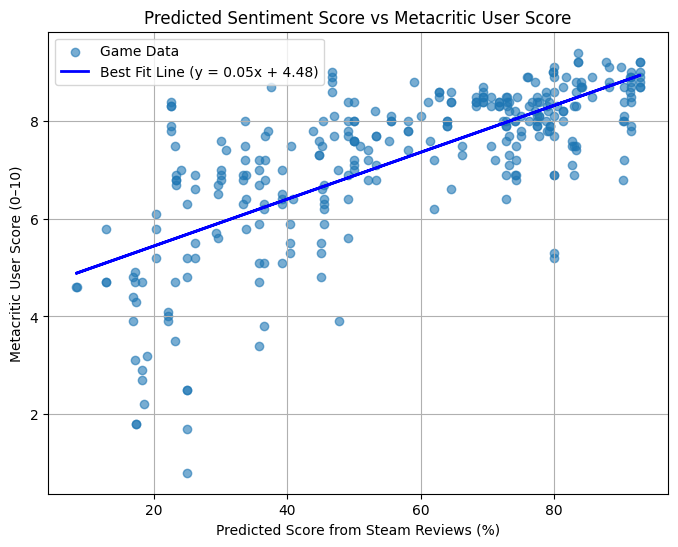

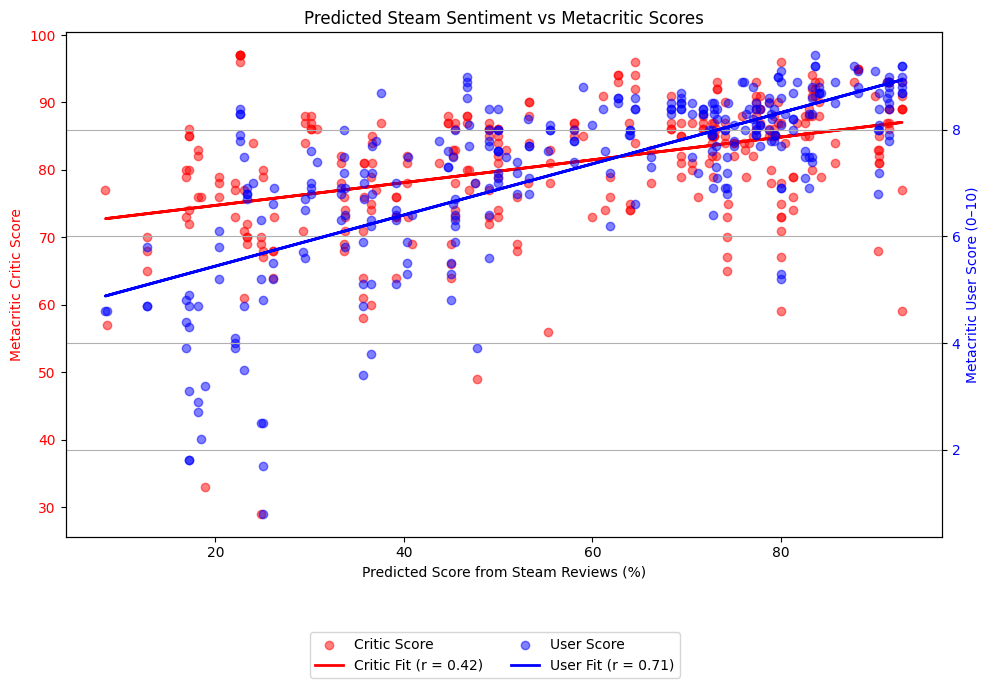

In [9]:
# analysis - steam model prediction vs metacritic scores
# note - metacritic has scores from critics and users
# first plot is critics, second plot is users, third plot is both of them

# run predictions on filtered_balanced
filtered_balanced['predicted'] = rf_model.predict(vectorizer.transform(filtered_balanced['review']))

# group reviews by game to compute % positive
game_sentiment = filtered_balanced.groupby('app_name')['predicted'].mean().reset_index()
game_sentiment.columns = ['game', 'predicted_positive_ratio']
game_sentiment['predicted_score'] = game_sentiment['predicted_positive_ratio'] * 100
game_sentiment['game_lower'] = game_sentiment['game'].str.lower()

# lowercase game names
games_df['name'] = games_df['name'].str.lower()
game_sentiment['game_lower'] = game_sentiment['game'].str.lower()

# merge predicted sentiment with metacritic scores
merged_scores = pd.merge(
    game_sentiment,
    games_df[['name', 'meta_score']],
    left_on='game_lower',
    right_on='name'
)
merged_scores.dropna(subset=['meta_score'], inplace=True)

# calculate correlation between predicted steam sentiment and metacritic scores
corr = merged_scores['predicted_score'].corr(merged_scores['meta_score'])
print(f"Correlation between predicted Steam sentiment and Metacritic CRITIC score: {corr:.2f}")

# plotting results
x = merged_scores['predicted_score']
y = merged_scores['meta_score']

# fit line
slope, intercept = np.polyfit(x, y, 1)
best_fit = slope * x + intercept

# plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label='Game Data')
plt.plot(x, best_fit, color='red', linewidth=2, label=f'Best Fit Line (y = {slope:.2f}x + {intercept:.2f})')
plt.xlabel("Predicted Score from Steam Reviews (%)")
plt.ylabel("Metacritic Critic Score")
plt.title("Predicted Sentiment Score vs Metacritic Critic Score")
plt.legend()
plt.grid(True)
plt.show()


# second plot for user scores
# convert user_review to numeric
games_df['user_review'] = pd.to_numeric(games_df['user_review'], errors='coerce')
games_df.dropna(subset=['user_review'], inplace=True)

# merge with game_sentiment
merged_user = pd.merge(
    game_sentiment,
    games_df[['name', 'user_review']],
    left_on='game_lower',
    right_on='name'
)

# calculate correlation between predicted steam sentiment and metacritic user scores
user_corr = merged_user['predicted_score'].corr(merged_user['user_review'])
print(f"Correlation between predicted Steam sentiment and Metacritic USER score: {user_corr:.2f}")

# plotting results
x_user = merged_user['predicted_score']
y_user = merged_user['user_review']

# fit line
slope_user, intercept_user = np.polyfit(x_user, y_user, 1)
best_fit_user = slope_user * x_user + intercept_user

# plot
plt.figure(figsize=(8, 6))
plt.scatter(x_user, y_user, alpha=0.6, label='Game Data')
plt.plot(x_user, best_fit_user, color='blue', linewidth=2, label=f'Best Fit Line (y = {slope_user:.2f}x + {intercept_user:.2f})')
plt.xlabel("Predicted Score from Steam Reviews (%)")
plt.ylabel("Metacritic User Score (0–10)")
plt.title("Predicted Sentiment Score vs Metacritic User Score")
plt.legend()
plt.grid(True)
plt.show()


# final comparison plot - user scores vs critic scores vs predicted steam sentiment
fig, ax1 = plt.subplots(figsize=(10, 6))

# critic score side
x1 = merged_scores['predicted_score']
y1 = merged_scores['meta_score']
slope1, intercept1 = np.polyfit(x1, y1, 1)
line1 = slope1 * x1 + intercept1

color1 = "red"
ax1.set_xlabel("Predicted Score from Steam Reviews (%)")
ax1.set_ylabel("Metacritic Critic Score", color=color1)
ax1.scatter(x1, y1, alpha=0.5, label="Critic Score", color=color1)
ax1.plot(x1, line1, color=color1, linewidth=2, label=f"Critic Fit (r = {corr:.2f})")
ax1.tick_params(axis='y', labelcolor=color1)

# user score side
ax2 = ax1.twinx()

x2 = merged_user['predicted_score']
y2 = merged_user['user_review']
slope2, intercept2 = np.polyfit(x2, y2, 1)
line2 = slope2 * x2 + intercept2

color2 = "blue"
ax2.set_ylabel("Metacritic User Score (0–10)", color=color2)
ax2.scatter(x2, y2, alpha=0.5, label="User Score", color=color2)
ax2.plot(x2, line2, color=color2, linewidth=2, label=f"User Fit (r = {user_corr:.2f})")
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Predicted Steam Sentiment vs Metacritic Scores")
fig.tight_layout()
plt.grid(True)
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [30]:
# additional bonus stat - most common words

# separate by sentiment
pos_texts = filtered_balanced[filtered_balanced['label'] == 1]['review']
neg_texts = filtered_balanced[filtered_balanced['label'] == 0]['review']

# vectorize both separately
pos_vec = vectorizer.transform(pos_texts)
neg_vec = vectorizer.transform(neg_texts)

# calculate word frequencies + total words in each group
feature_names = vectorizer.get_feature_names_out()
pos_sum = pos_vec.sum(axis=0)
neg_sum = neg_vec.sum(axis=0)

# each word's frequency
pos_freq = [(word, pos_sum[0, idx]) for idx, word in enumerate(feature_names)]
neg_freq = [(word, neg_sum[0, idx]) for idx, word in enumerate(feature_names)]

# top 10 words in each group
top_pos = sorted(pos_freq, key=lambda x: x[1], reverse=True)[:10]
top_neg = sorted(neg_freq, key=lambda x: x[1], reverse=True)[:10]

print("\ntop 10 most common words in POSITIVE reviews:")
for word, freq in top_pos:
    print(f"{word}: {int(freq)}")

print("\ntop 10 most common words in NEGATIVE reviews:")
for word, freq in top_neg:
    print(f"{word}: {int(freq)}")

# from the top words for each we can see a pattern the models may use:
# positively correlated words like fun, love, 10 (likely from 10/10), best, friends, great etc
# negatively correlated words like money, time (likely from waste of time and money), buy, don (likely from don't buy) etc 


top 10 most common words in POSITIVE reviews:
game: 776
fun: 386
good: 346
10: 307
great: 298
best: 282
play: 261
like: 214
games: 180
played: 177

top 10 most common words in NEGATIVE reviews:
game: 726
just: 256
play: 225
like: 219
don: 166
buy: 165
good: 161
time: 160
money: 158
fun: 147


In [65]:
# additional bonus stat - sample reviews

# predictions stored
filtered_balanced['predicted'] = rf_model.predict(vectorizer.transform(filtered_balanced['review']))

# one random positive review
pos_sample = filtered_balanced[filtered_balanced['label'] == 1].sample(1).iloc[0]
wrapped_pos_review = textwrap.fill(pos_sample['review'], width=100)
print("\nPositive Review Sample")
print(f"Game: {pos_sample['app_name']}")
print(f"Review:\n{wrapped_pos_review}")
print(f"Model Prediction: {'Correct' if pos_sample['predicted'] == pos_sample['label'] else 'Incorrect'}")

print("\n------------------------------------")

# one random negative review
neg_sample = filtered_balanced[filtered_balanced['label'] == 0].sample(1).iloc[0]
wrapped_neg_review = textwrap.fill(neg_sample['review'], width=100)
print("\nNegative Review Sample")
print(f"Game: {neg_sample['app_name']}")
print(f"Review:\n{wrapped_neg_review}")
print(f"Model Prediction: {'Correct' if neg_sample['predicted'] == neg_sample['label'] else 'Incorrect'}")


Positive Review Sample
Game: Sid Meier's Civilization V
Review:
Never played a Civ game before, always been more of a real time fan, having got this, I spent HOURS
on it, lots of fun even more with friends with co-op or agaist each other...  Multiplayer can bug
out now and then but nothing a few saves can't fix. Would recomment this to anyone who likes to
build empires, create massive tradeing powers, or anyone who likes to roll over people with a
massive army, so many ways to play so many ways to have fun.
Model Prediction: Incorrect

------------------------------------

Negative Review Sample
Game: Among Us
Review:
absolute garbage its fun the first few times you play, but then theres a hacker in each game. this
game is so repetitive. if you want to play, play on your phone or ipad first and see if you like it.
Model Prediction: Correct
